PART 1

In [4]:
import torch
from PIL import Image
import requests

In [5]:
from transformers import ViTImageProcessor, ViTForImageClassification

In [8]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_class_idx]

print(f"Predicted class index: {predicted_class_idx}")
print(f"Predicted label: {predicted_label}")

Predicted class index: 281
Predicted label: tabby, tabby cat


PART 2

In [14]:
import numpy as np
import matplotlib.pyplot as plt

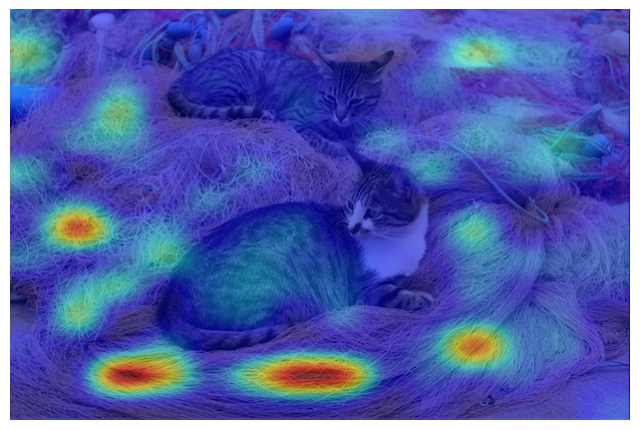

In [15]:
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

last_attn = attentions[-1][0]

avg_attn = last_attn.mean(dim=0)

cls_attn = avg_attn[0, 1:]

num_patches = int(cls_attn.shape[0] ** 0.5)
cls_attn_map = cls_attn.reshape(num_patches, num_patches).detach().numpy()

cls_attn_map = (cls_attn_map - cls_attn_map.min()) / (cls_attn_map.max() - cls_attn_map.min())

cls_attn_map = np.array(Image.fromarray((cls_attn_map * 255).astype(np.uint8)).resize(image.size))

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.imshow(cls_attn_map, cmap="jet", alpha=0.5)  # heatmap overlay
plt.axis("off")
plt.show()

In [16]:
def mask_random(image, fraction=0.3, patch_size=16):
    """Randomly mask patches in the image."""
    img = np.array(image).copy()
    H, W, C = img.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    total_patches = num_patches_h * num_patches_w

    # number of patches to mask
    num_to_mask = int(fraction * total_patches)
    mask_idxs = np.random.choice(total_patches, num_to_mask, replace=False)

    for idx in mask_idxs:
        i = idx // num_patches_w
        j = idx % num_patches_w
        img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0
    return Image.fromarray(img)

def mask_center(image, patch_size=16, size=4):
    """Mask a centered square block of patches."""
    img = np.array(image).copy()
    H, W, C = img.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # center block
    start_h = num_patches_h//2 - size//2
    start_w = num_patches_w//2 - size//2

    for i in range(start_h, start_h+size):
        for j in range(start_w, start_w+size):
            img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0
    return Image.fromarray(img)

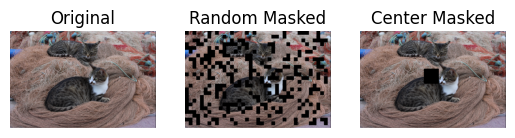

Random Masked Prediction: crossword puzzle, crossword
Center Masked Prediction: tabby, tabby cat


In [19]:
# Test both masking methods
random_masked = mask_random(image, fraction=0.3)
center_masked = mask_center(image, size=4)

# Show them
plt.subplot(1, 3, 1)
plt.imshow(image); plt.title("Original"); plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(random_masked); plt.title("Random Masked"); plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(center_masked); plt.title("Center Masked"); plt.axis("off")
plt.show()

# Run through model to see predictions
for masked_img, name in [(random_masked, "Random"), (center_masked, "Center")]:
    inputs = processor(images=masked_img, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    pred = model.config.id2label[outputs.logits.argmax(-1).item()]
    print(f"{name} Masked Prediction: {pred}")